In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import csv
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Machine Learning//'

df = pd.read_csv(path+ 'NESTLEIND.csv')


In [ ]:
# data.drop(columns=['symbol'], inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2010-01-08,NESTLEIND,EQ,2512.95,2555.00,2575.0,2475.20,2476.0,2494.65,2529.81,648,1.639316e+11,NaN,438,0.6759
1,2010-01-11,NESTLEIND,EQ,2494.65,2401.00,2515.0,2400.00,2500.0,2498.95,2494.44,825,2.057909e+11,NaN,638,0.7733
2,2010-01-12,NESTLEIND,EQ,2498.95,2540.00,2540.0,2471.35,2505.0,2502.85,2485.22,68346,1.698549e+13,NaN,67695,0.9905
3,2010-01-13,NESTLEIND,EQ,2502.85,2502.85,2540.0,2480.00,2489.8,2489.35,2491.94,1032,2.571682e+11,NaN,718,0.6957
4,2010-01-14,NESTLEIND,EQ,2489.35,2535.00,2595.0,2470.00,2560.0,2568.20,2510.27,330361,8.292956e+13,NaN,329193,0.9965


In [ ]:
display(df.shape)

(2806, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2806 entries, 0 to 2805
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2806 non-null   object 
 1   Symbol              2806 non-null   object 
 2   Series              2806 non-null   object 
 3   Prev Close          2806 non-null   float64
 4   Open                2806 non-null   float64
 5   High                2806 non-null   float64
 6   Low                 2806 non-null   float64
 7   Last                2806 non-null   float64
 8   Close               2806 non-null   float64
 9   VWAP                2806 non-null   float64
 10  Volume              2806 non-null   int64  
 11  Turnover            2806 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  2806 non-null   int64  
 14  %Deliverble         2806 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 329.0

In [ ]:
# Chuyển đổi cột Date thành định dạng datetime
df['Date'] = pd.to_datetime(df['Date'])

# Loại các giá trị chứa NaN
df = df.dropna()
df = df.dropna(axis=1)
# Kiểm tra lại dữ liệu sau khi làm sạch
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2456 entries, 350 to 2805
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2456 non-null   datetime64[ns]
 1   Symbol              2456 non-null   object        
 2   Series              2456 non-null   object        
 3   Prev Close          2456 non-null   float64       
 4   Open                2456 non-null   float64       
 5   High                2456 non-null   float64       
 6   Low                 2456 non-null   float64       
 7   Last                2456 non-null   float64       
 8   Close               2456 non-null   float64       
 9   VWAP                2456 non-null   float64       
 10  Volume              2456 non-null   int64         
 11  Turnover            2456 non-null   float64       
 12  Trades              2456 non-null   float64       
 13  Deliverable Volume  2456 non-null   int64         


In [ ]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
350,2011-06-01,NESTLEIND,EQ,4059.30,4065.1,4134.00,4065.0,4103.0,4104.45,4083.00,24513,1.000865e+13,1265.0,18592,0.7585
351,2011-06-02,NESTLEIND,EQ,4104.45,4070.0,4139.00,4060.1,4102.0,4105.20,4112.36,8774,3.608181e+12,1434.0,5033,0.5736
352,2011-06-03,NESTLEIND,EQ,4105.20,4120.0,4140.75,4088.0,4090.1,4093.25,4107.22,3699,1.519259e+12,1046.0,2146,0.5802
353,2011-06-06,NESTLEIND,EQ,4093.25,4130.0,4150.00,4072.1,4140.0,4141.25,4129.71,7083,2.925075e+12,1570.0,4110,0.5803
354,2011-06-07,NESTLEIND,EQ,4141.25,4149.0,4173.90,4106.3,4161.0,4165.10,4142.66,7831,3.244117e+12,1193.0,5865,0.7489


In [ ]:
print(f'Dataframe contains stock prices between {df.Date.min()} {df.Date.max()}')
print(f'Total days = {(df.Date.max()  - df.Date.min()).days} days')

Dataframe contains stock prices between 2011-06-01 00:00:00 2021-04-30 00:00:00
Total days = 3621 days


In [ ]:
df.describe()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,2456,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2.456000e+03,2.456000e+03,2456.000000,2456.000000,2456.000000
mean,2016-05-12 15:18:45.732899328,8116.981026,8128.994218,8220.661523,8029.358388,8121.078929,8121.968791,8124.362936,5.835114e+04,6.148337e+13,11043.311075,35074.405130,0.654435
min,2011-06-01 00:00:00,3887.900000,3879.000000,3936.900000,3855.000000,3876.350000,3887.900000,3896.220000,3.050000e+02,1.258474e+11,63.000000,135.000000,0.131000
25%,2013-11-13 18:00:00,4999.362500,4992.250000,5047.225000,4947.500000,4999.475000,5000.375000,5002.835000,1.958725e+04,1.086018e+13,3400.000000,12943.750000,0.537600
50%,2016-05-16 12:00:00,6378.675000,6388.500000,6480.975000,6306.225000,6380.000000,6381.350000,6380.035000,3.704750e+04,2.342578e+13,6352.000000,24559.000000,0.660850
75%,2018-11-05 06:00:00,10393.750000,10402.250000,10552.575000,10272.162500,10411.250000,10395.487500,10407.077500,7.224775e+04,6.842641e+13,14116.500000,43857.000000,0.779375
max,2021-04-30 00:00:00,18732.700000,18844.000000,18844.000000,18520.000000,18720.000000,18732.700000,18683.520000,1.106746e+06,1.979044e+15,122364.000000,929598.000000,0.988800
std,NaN,4117.431773,4126.472834,4172.316441,4069.422878,4119.526643,4119.933285,4119.932963,7.028896e+04,1.002042e+14,12405.830784,43911.649744,0.163143


<Axes: >

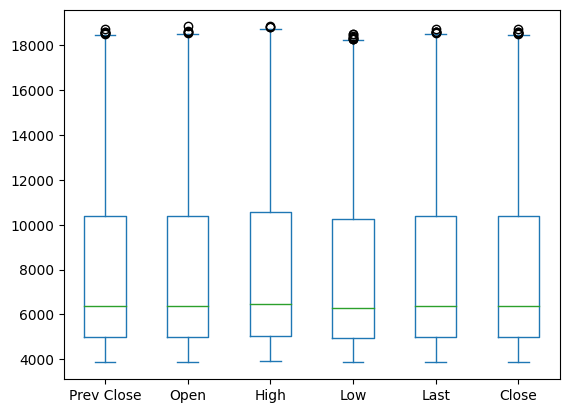

In [ ]:
df[['Date', 'Prev Close', 'Open','High','Low', 'Last', 'Close',]].plot(kind='box')

In [ ]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
350,2011-06-01,NESTLEIND,EQ,4059.30,4065.1,4134.00,4065.0,4103.0,4104.45,4083.00,24513,1.000865e+13,1265.0,18592,0.7585
351,2011-06-02,NESTLEIND,EQ,4104.45,4070.0,4139.00,4060.1,4102.0,4105.20,4112.36,8774,3.608181e+12,1434.0,5033,0.5736
352,2011-06-03,NESTLEIND,EQ,4105.20,4120.0,4140.75,4088.0,4090.1,4093.25,4107.22,3699,1.519259e+12,1046.0,2146,0.5802
353,2011-06-06,NESTLEIND,EQ,4093.25,4130.0,4150.00,4072.1,4140.0,4141.25,4129.71,7083,2.925075e+12,1570.0,4110,0.5803
354,2011-06-07,NESTLEIND,EQ,4141.25,4149.0,4173.90,4106.3,4161.0,4165.10,4142.66,7831,3.244117e+12,1193.0,5865,0.7489


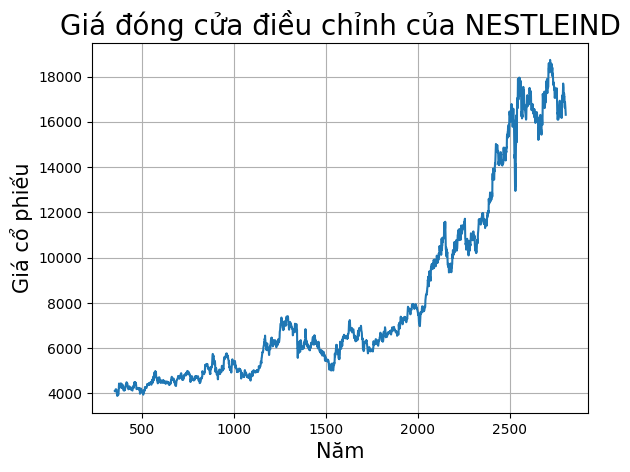

In [ ]:
# Plot giá vào
df['Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Giá đóng cửa điều chỉnh của NESTLEIND', color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá cổ phiếu', color = 'black', fontsize = 15);

****





# **UNIQUE**

In [ ]:
# Kiểm tra các giá trị duy nhất trong từng cột
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column '{column}' has {len(unique_values)} unique values")


Column 'Date' has 2456 unique values
Column 'Symbol' has 1 unique values
Column 'Series' has 1 unique values
Column 'Prev Close' has 2435 unique values
Column 'Open' has 2076 unique values
Column 'High' has 2122 unique values
Column 'Low' has 2160 unique values
Column 'Last' has 2007 unique values
Column 'Close' has 2435 unique values
Column 'VWAP' has 2450 unique values
Column 'Volume' has 2426 unique values
Column 'Turnover' has 2456 unique values
Column 'Trades' has 2306 unique values
Column 'Deliverable Volume' has 2413 unique values
Column '%Deliverble' has 2023 unique values


Đường trung bình động - Moving Average

*   List item
*   List item



Đường trung bình động là một chỉ số phân tích kỹ thuật đơn giản, theo đó quan sát tiếp theo là giá trị trung bình của tất cả các quan sát trong quá khứ tạo ra một mức giá trung bình được cập nhật liên tục.



In [ ]:
# Tạo DataFrame cho Giá đóng cửa

msft_adj = df[['Close']]
msft_adj

,Close
350,4104.45
351,4105.20
352,4093.25
353,4141.25
354,4165.10
...,...
2801,16870.60
2802,16779.00
2803,16633.80
2804,16502.55



### Split dữ liệu

Chúng ta sẽ chia dữ liệu thành train set và test set để xác minh kết quả dự đoán. Vì đây là dữ liệu dạng Time series nên ta không thể chia ngẫu nhiên được. Vậy nên là ta sẽ chia 80% đầu là train set và 20% còn lại là test set.

In [ ]:
# Tạo split tỉ lệ 80%/20%

split = int(0.8*len(msft_adj))

In [ ]:
# Chia thành train và test set

train, test = msft_adj[:split], msft_adj[split:]

In [ ]:
msft_adj.shape, train.shape, test.shape

((2456, 1), (1964, 1), (492, 1))

In [ ]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(350, 2313, 2314, 2805)

### Tạo dự đoán cho test set

In [ ]:
# Tạo dự đoán
preds = []
for i in range(0,492):
    a = train[len(train)-492+i:].sum() + sum(preds)
    b = a/492
    preds.append(b)

### Tính chỉ số RMSE

Chúng ta sẽ đánh giá mô hình bằng cách tính toán chỉ số RMSE hoặc Độ lệch gốc-trung bình-bình phương (Root-mean-square deviation), một thước đo tốt để xem xét mức độ chính xác của các mô hình dự đoán phản hồi.

In [ ]:
# Tính rmse
rmse = np.sqrt(np.mean(np.power((np.array(test)-preds),2)))
rmse

6006.1415307835505

### Trực quan hóa các dữ liệu dự đoán và thực tế

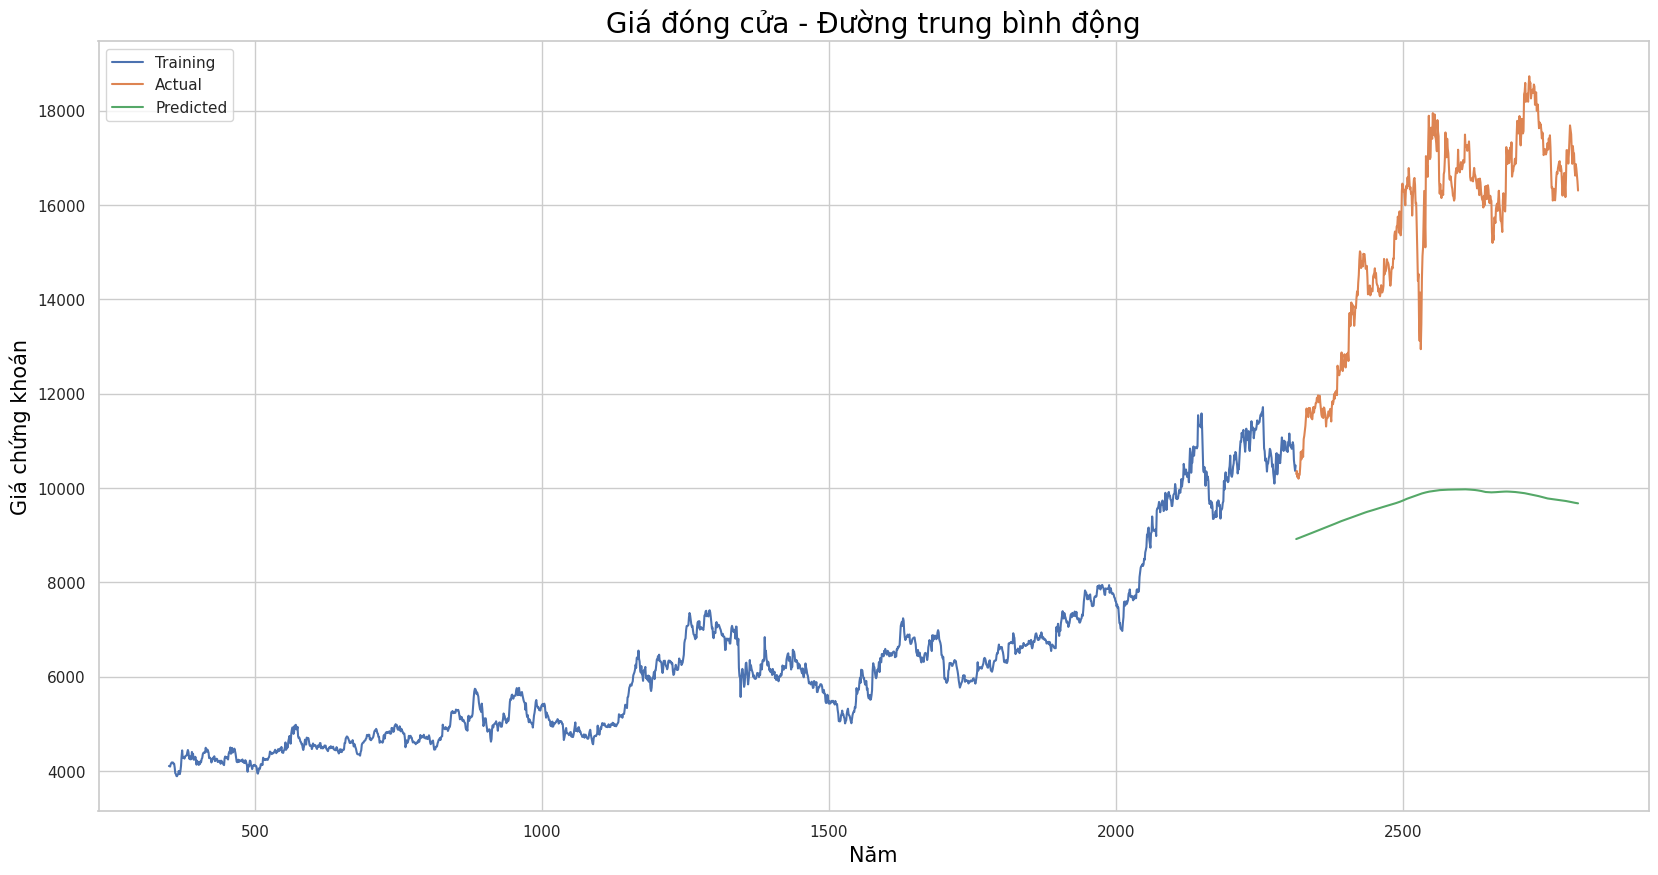

In [ ]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(train, label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Giá đóng cửa - Đường trung bình động", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Các giá trị dự đoán ban đầu cho thấy xu hướng tăng, sau đó chững lại và bắt đầu giảm dần.

 Hồi quy tuyến tính - Linear Regression

Mô hình này áp dụng cách tiếp cận tuyến tính để mô hình hóa mối quan hệ giữa biến phụ thuộc và (các) biến độc lập, đồng thời cũng là hình thức học máy đơn giản nhất.

In [ ]:
df['Date']

350    2011-06-01
351    2011-06-02
352    2011-06-03
353    2011-06-06
354    2011-06-07
          ...    
2801   2021-04-26
2802   2021-04-27
2803   2021-04-28
2804   2021-04-29
2805   2021-04-30
Name: Date, Length: 2456, dtype: datetime64[ns]

In [ ]:
msft_adj['Date'] = pd.to_datetime(msft_adj.index)
msft_adj.index = msft_adj['Date']

In [ ]:
msft_adj.head()

,Close,Date
Date,,
1970-01-01 00:00:00.000000350,4104.45,1970-01-01 00:00:00.000000350
1970-01-01 00:00:00.000000351,4105.20,1970-01-01 00:00:00.000000351
1970-01-01 00:00:00.000000352,4093.25,1970-01-01 00:00:00.000000352
1970-01-01 00:00:00.000000353,4141.25,1970-01-01 00:00:00.000000353
1970-01-01 00:00:00.000000354,4165.10,1970-01-01 00:00:00.000000354


In [ ]:
# Thiết lập cột 'Date' làm chỉ mục của DataFrame
# msft_adj.set_index('Date', inplace=True)

In [ ]:
# Tạo tập dữ liệu riêng cho giá đóng cửa điều chỉnh
msft_adj = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(350,len(df)):
     msft_adj['Date'][i] = df.index[i]
     msft_adj['Close'][i] = df['Close'][i]

### Feature engineering (tạm dịch: Trích chọn đặc trưng)

Giả thuyết cho rằng, những ngày đầu tiên và cuối cùng trong tuần có khả năng ảnh hưởng nhiều đến giá đóng cửa điều chỉnh. Vì vậy chúng ta sẽ thêm một tính năng để phân loại các ngày dựa vào ngày trong tuần của chúng.

Nếu số ngày là 0 (thứ hai) hoặc 4(thứ sáu) thì cột ghi chú sẽ hiện thị 1, và ngược lại, nếu ngày rơi vào thứ ba, tư, năm, cột hiện thị sẽ ghi là 0.

In [ ]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype

    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)

    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

    if time:
        attr += ['Hour', 'Minute', 'Second']

    for n in attr:
        if n == 'Week':
            df[targ_pre + n] = fld.dt.isocalendar().week
        else:
            df[targ_pre + n] = getattr(fld.dt, n.lower())

    df[targ_pre + 'Elapsed'] = fld.view(np.int64) // 10**9

    if drop:
        df.drop(fldname, axis=1, inplace=True)

In [ ]:
# Gọi function để thêm các thành phần ngày/thời gian
add_datepart(msft_adj, 'Date')
msft_adj.drop('Elapsed', axis=1, inplace=True)

In [ ]:
print(msft_adj)

         Close    Year  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end  \
0          NaN     NaN    NaN  <NA>  NaN        NaN        NaN         False   
1          NaN     NaN    NaN  <NA>  NaN        NaN        NaN         False   
2          NaN     NaN    NaN  <NA>  NaN        NaN        NaN         False   
3          NaN     NaN    NaN  <NA>  NaN        NaN        NaN         False   
4          NaN     NaN    NaN  <NA>  NaN        NaN        NaN         False   
...        ...     ...    ...   ...  ...        ...        ...           ...   
2451   16870.6  1970.0    1.0     1  1.0        3.0        1.0         False   
2452   16779.0  1970.0    1.0     1  1.0        3.0        1.0         False   
2453   16633.8  1970.0    1.0     1  1.0        3.0        1.0         False   
2454  16502.55  1970.0    1.0     1  1.0        3.0        1.0         False   
2455  16309.25  1970.0    1.0     1  1.0        3.0        1.0         False   

      Is_month_start  Is_quarter_end  I

In [ ]:
# Print cột
msft_adj.columns

Index(['Close', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start'],
      dtype='object')

In [ ]:
# Tạo tính năng
msft_adj['mon_fri'] = 0
for i in range(0,len(msft_adj)):
    if (msft_adj['Dayofweek'][i] == 0 or msft_adj['Dayofweek'][i] == 4):
        msft_adj['mon_fri'][i] = 1
    else:
        msft_adj['mon_fri'][i] = 0

### Split data thành train và test set

In [ ]:
split = int(0.8*len(msft_adj))

In [ ]:
train, test = msft_adj[:split], msft_adj[split:]

In [ ]:
msft_adj.shape, train.shape, test.shape

((2456, 14), (1964, 14), (492, 14))

In [ ]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']
X_test = test.drop('Close', axis=1)
y_test = test['Close']

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1964, 13), (1964,), (492, 13), (492,))

In [ ]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

### Tạo và train mô hình Hồi quy tuyến tính


In [ ]:
# Tạo model
model = LinearRegression()

# Train model
model.fit(X_train,y_train)

LinearRegression()

### Test model

In [ ]:
# Tạo dự báo
preds = model.predict(X_test)
print(preds)

[6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.01409542 6717.01409542 6717.01409542 6717.01409542 6717.01409542
 6717.

### Tính chỉ số RMSE

In [ ]:
rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rmse

8927.044365250997

### Trực quan hóa các dữ liệu dự đoán và thực tế

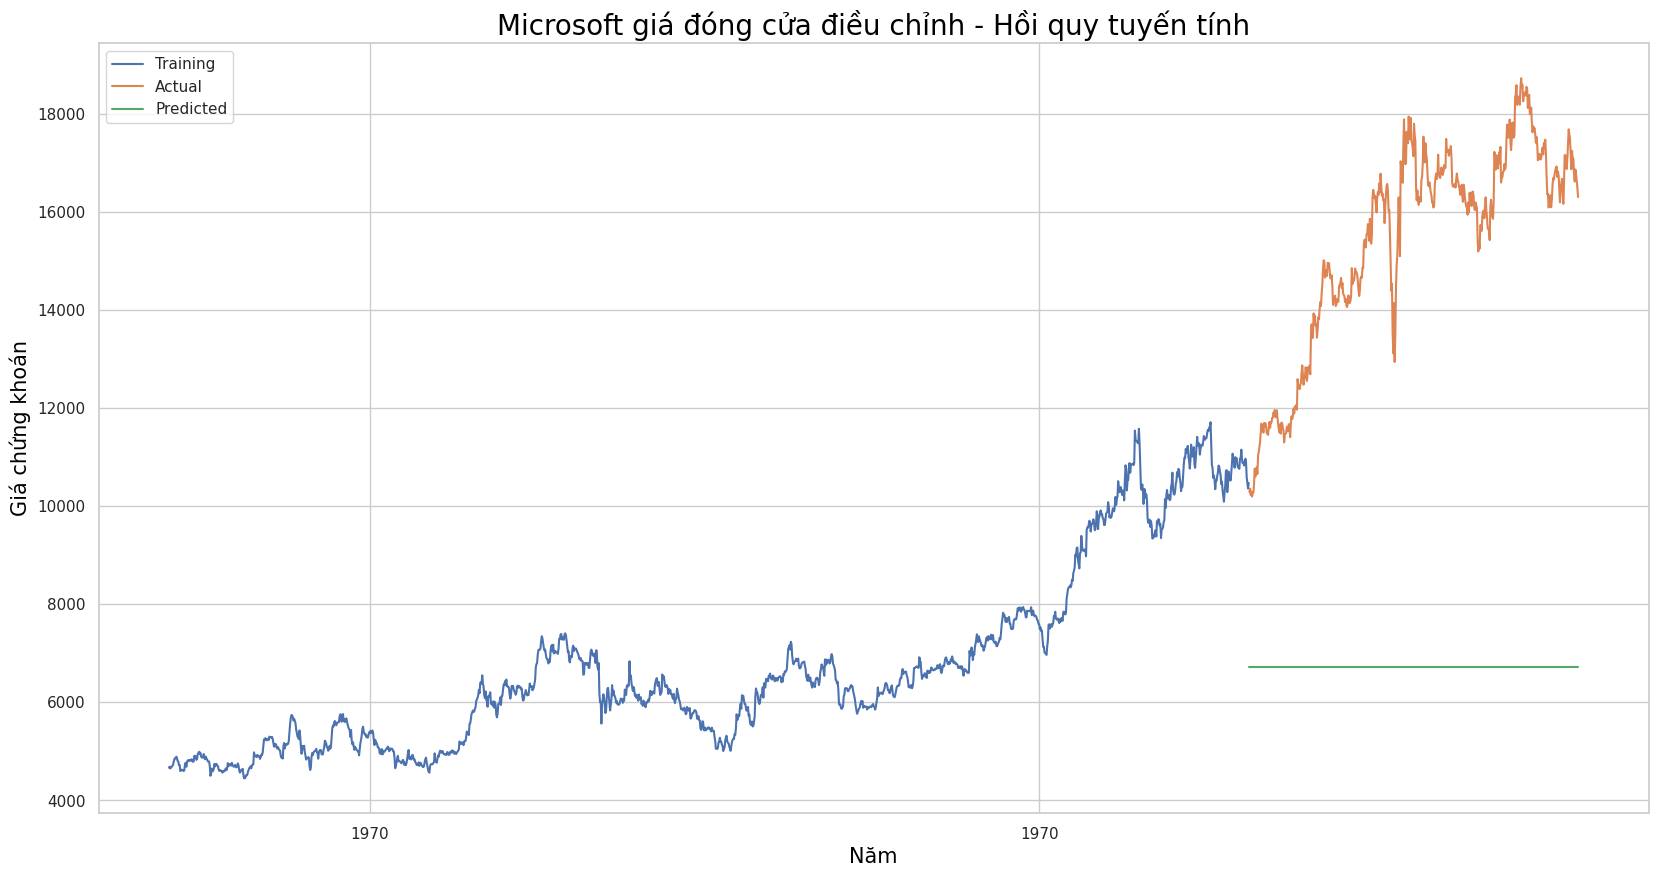

In [ ]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

test.index = df[split:].index
train.index = df[:split].index

plt.plot(train['Close'], label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Microsoft giá đóng cửa điều chỉnh - Hồi quy tuyến tính", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Giá trị RMSE thấp hơn so với Đường trung bình động

 k-Nearest Neighbours

Dựa trên các biến độc lập, k-Nearest Neighbors tìm thấy sự giống nhau giữa các điểm dữ liệu mới, cũ và giả định rằng các điểm dữ liệu tương tự tồn tại ở gần nhau. Nó chọn k cho “hàng xóm” gần nhất và sau đó dựa trên những “hàng xóm” này để dự đoán một giá trị cho quan sát mới. k-Nearest Neighbours được biết đến như là một mô hình machine learning đơn giản.

### Feature scaling (tạm dịch: Scaling trích chọn)

In [ ]:
# Normalisation - thay đổi tỷ lệ dữ liệu để tất cả các giá trị nằm trong phạm vi 0 và 1
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

### GridSearch tìm tham số tối ưu

In [ ]:
# Tạo thư viện cho tham số
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
# Tạo model
knn = KNeighborsRegressor()
# Dùng GridSearch để tìm tham số tối ưu
model = GridSearchCV(knn, params, cv=5)

### Train và test model

In [ ]:
# Fit model và tạo dự đoán
model.fit(X_train,y_train)
preds = model.predict(X_test)

### Tính chỉ số RMSE

In [ ]:
rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rmse

10880.199230135033

### Trực quan hóa các dữ liệu dự đoán và thực tế

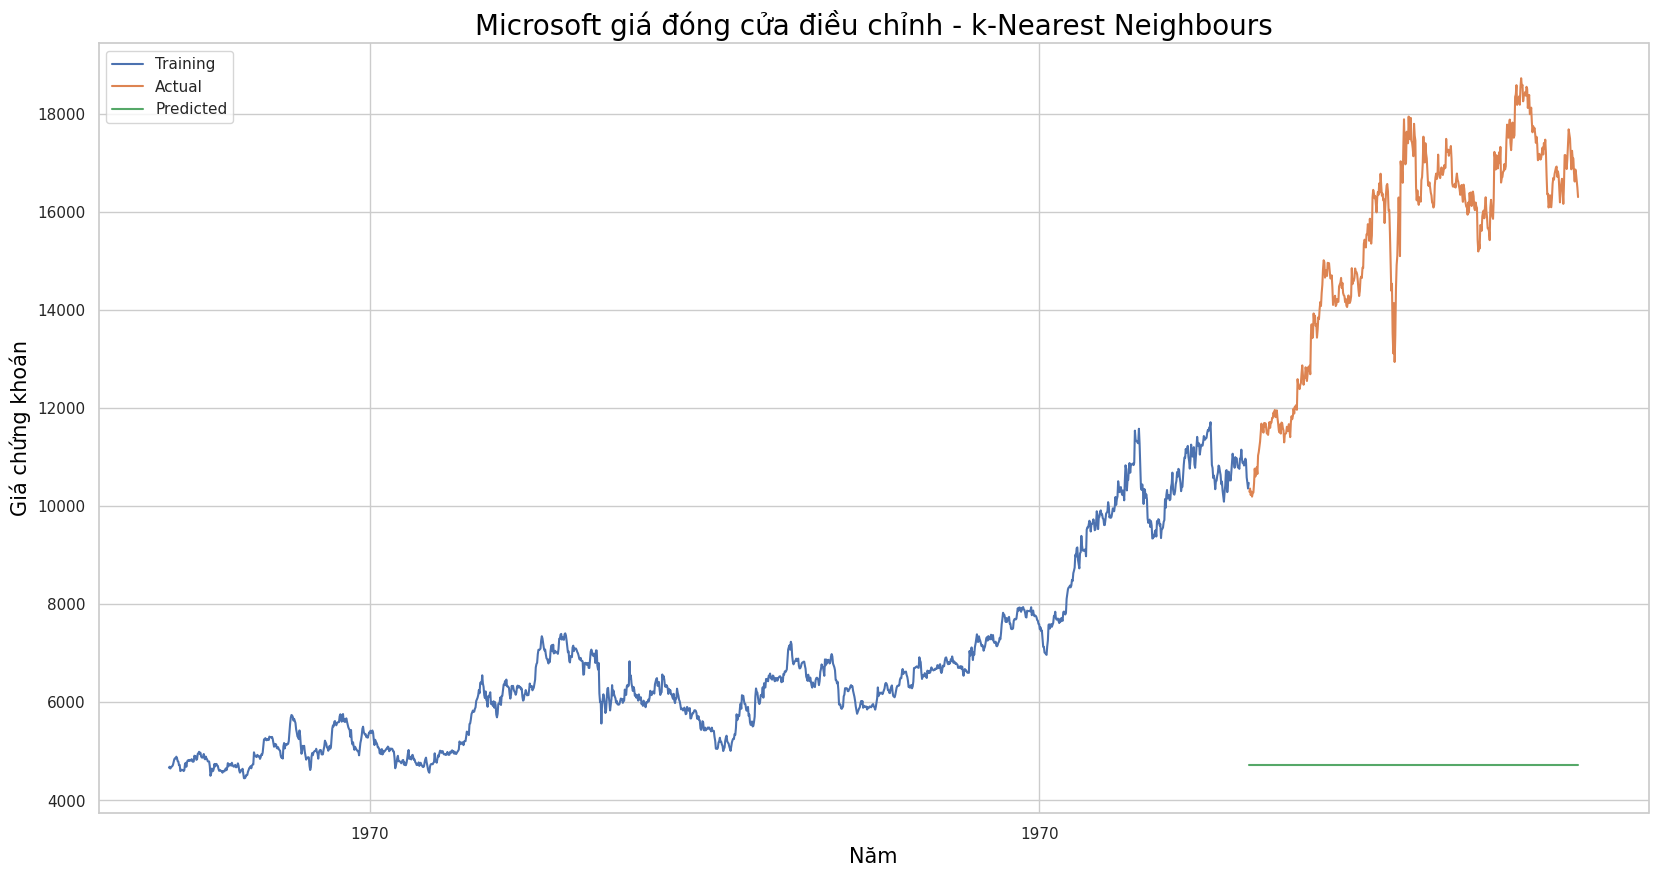

In [ ]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

plt.plot(train['Close'], label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Microsoft giá đóng cửa điều chỉnh - k-Nearest Neighbours", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Từ ba biểu đồ trên, có vẻ như các thuật toán hồi quy không thực sự hoạt động tốt trên tập dữ liệu chuỗi thời gian này.

Bằng cách sử dụng dữ liệu trong quá khứ để phân tích và hiểu được các hình mẫu trong chuỗi thời gian, các mô hình đã nắm bắt được xu hướng ngày càng tăng trong chuỗi và đạt đến được RMSE thấp nhất cho đến hiện tại


 Long Short Term Memory (LSTM)

LSTM là một Recurrent Neural Network (tạm dịch: Mạng thần kinh tái phát) có thể lưu trữ những thông tin quan trọng trong quá khứ và quên đi những thông tin không quan trọng. Nó sử dụng các quy trình bộ nhớ ngắn hạn để tạo ra bộ nhớ dài hơn và giới thiệu khái niệm về cổng để kiểm soát luồng thông tin trong mạng lưới bằng cách có cơ chế cổng đầu vào, đầu ra và cổng quên.

In [ ]:
# Tạo DataFrame cho Giá đóng cửa điều chỉnh
msft_adj = msft_df[['Adj Close']]
msft_adj

,Adj Close
Date,
2010-01-04,23.68
2010-01-05,23.69
2010-01-06,23.55
2010-01-07,23.30
2010-01-08,23.46
...,...
2023-01-03,239.58
2023-01-04,229.10
2023-01-05,222.31


In [ ]:
# Chuyển DataFrame thành numpy array
msft_adj_arr = msft_adj.values

### Split data thành train và test set

In [ ]:
split = int(0.8*len(msft_adj_arr))

In [ ]:
train, test = msft_adj_arr[:split], msft_adj_arr[split:]

In [ ]:
train.shape, test.shape

((2621, 1), (656, 1))

### Feature scaling (tạm dịch: Scaling trích chọn)

Tiêu chuẩn hoá dữ liệu bằng cách scale dữ liệu thành định dạng từ 0 đến 1 để cải thiện việc học và tính hội tụ của mô hình.

In [ ]:
# Scaling trích chọn và fit dữ liệu scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(msft_adj_arr)

## Tạo dữ liệu training

In [ ]:
# Tạo cấu trúc dữ liệu với 60 time-steps và 1 output
# X_train chứa các mẫu huấn luyện
# y_train giá trị mục tiêu (labels)
X_train, y_train = [], []
for i in range(60, len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [ ]:
# Chuyển X_train và y_train thành numpy arrays cho mô hình LSTM training

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Chuyển dạng dữ liệu thành 3D theo định dạng yêu cầu của LSTM (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2561, 60, 1)

### Tạo và train model

Chúng ta sẽ triển khai một mô hình đơn giản bao gồm một lớp ẩn với 50 nơ-ron, hình dạng dữ liệu đầu vào với số bước thời gian (number of time steps) là (60) và số chiều (dimensionality) là (1) và một lớp đầu ra với bước thời gian là 1. Mô hình sẽ được biên dịch bằng Mean Squared Error (MSE) và trình tối ưu hóa ADAM (Adaptive Moment Estimation), sau đó sẽ được fit với training set với một epoch và batch size là một.

In [ ]:
# Tạo và fit mạng LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

# Dự đoán 504 giá trị, sự dụng 60 từ tập data train
inputs = msft_adj_arr [len(msft_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

2561/2561 - 30s - loss: 2.1690e-04 - 30s/epoch - 12ms/step


### Tạo test set và test

In [ ]:
# Tạo test data set
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

# Chuyển data thành numpy array
X_test = np.array(X_test)

# Chuyển data thành 3-D
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
adj_closing_price = model.predict(X_test)
adj_closing_price = scaler.inverse_transform(adj_closing_price)

21/21 [==============================] - 1s 8ms/step


In [ ]:
print(X_test.shape)

(656, 60, 1)


### Tính chỉ số RMSE

In [ ]:
rmse = np.sqrt(np.mean(np.power((test - adj_closing_price),2)))
rmse

6.650146577279944

### Trực quan hóa các dữ liệu dự đoán và thực tế

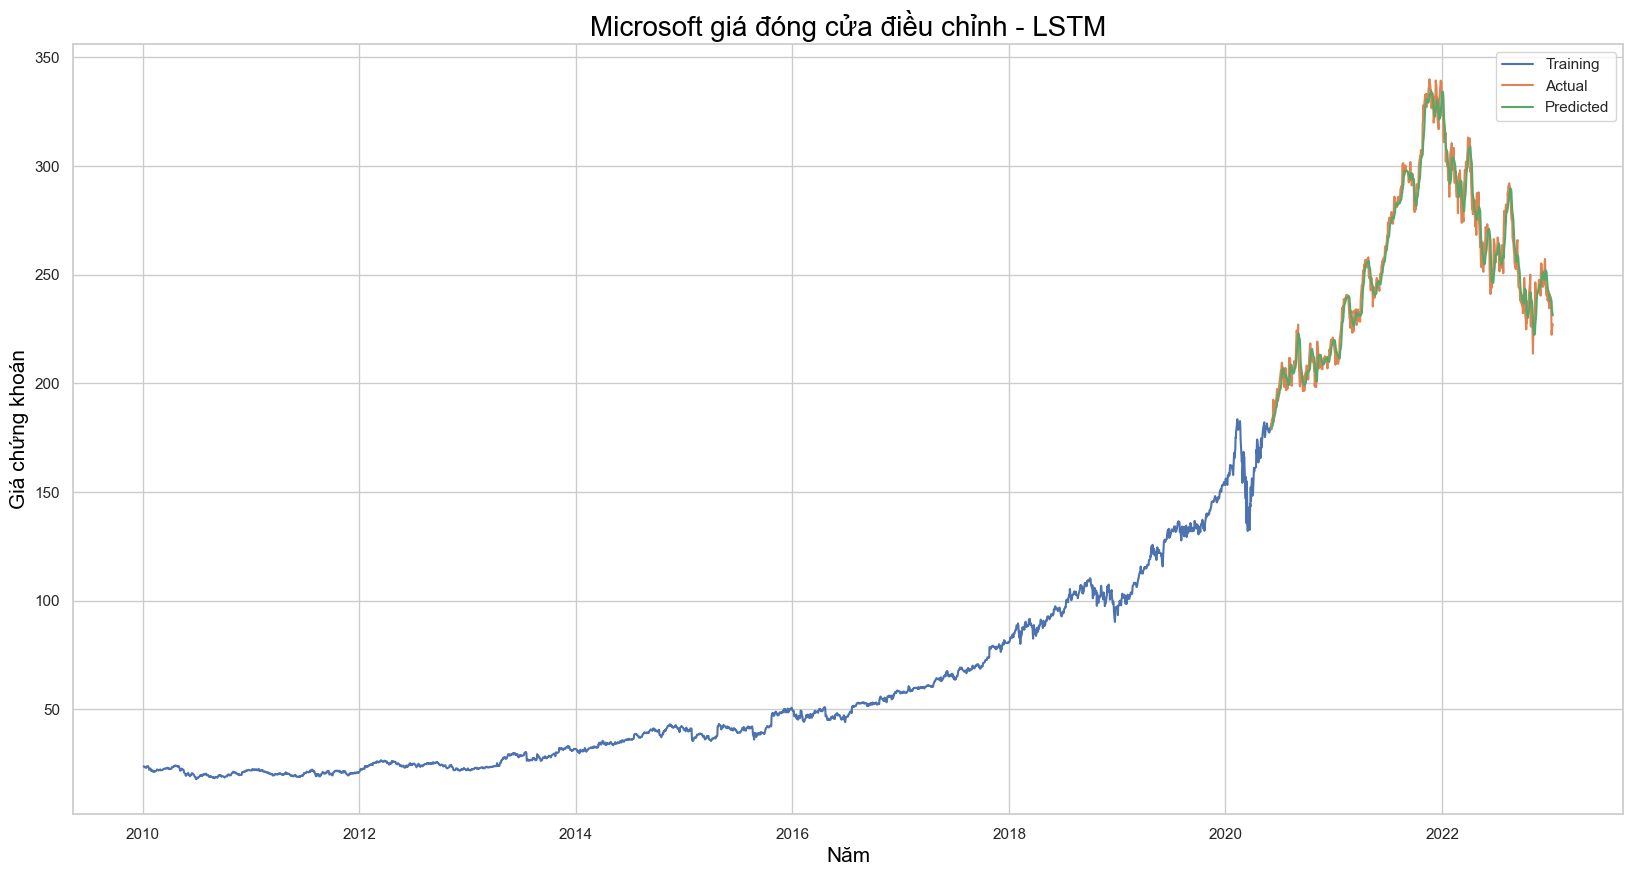

In [ ]:
# Plot thông số dự đoán và thực tế
train = msft_adj[:split]
test = msft_adj[split:]
test['Predictions'] = adj_closing_price

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Microsoft giá đóng cửa điều chỉnh - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Mô hình LSTM đã đạt được giá trị RMSE thấp nhất và dự đoán chính xác nhất. Dù rằng đây chỉ là một mô hình deep learning cơ bản song chúng ta có thể tiếp tục điều chỉnh nhiều tham số khác nhau, nhiều lớp có thể được thêm vào với các tính năng để chuẩn hóa và tăng số lượng epochs để mô hình có tính hội tụ tốt hơn.